# 1. Undersampling and Oversampling

In this notebook, I'll explore ways to help with our bad classifier predictions. While our accuracy was pretty high, our precision and recall weren't that good. As previously explained, this behaviour is expected because of our unbalanced dataset.

Some ways to help to prevent classifiers to generalise badly is to undersample and oversample our data and I'll explore what these concepts mean and how to use them properly.

Undersampling can be described as a way to reduce the imbalance in a dataset by removing data points from the classes that are in higher number in the dataset. Oversampling, meanwhile, is to produce more data points for the class that is in lower quantity in order to balance the dataset.

We can get a simplistic look at how it works here: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

I'll be using Sklearn's implementation of undersampling and oversampling techniques.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from imblearn import over_sampling, under_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix

import fraudutils as futils
import warnings

warnings.filterwarnings(action='once')

%load_ext autoreload
%autoreload 2
%matplotlib inline

I'll be loading the same data as before, but now I'll split it into train and test while maintaining its distributuin and I'll apply oversampling and undersampling techniques and compare the results of simple ML algorithms, both in accuracy, precision and recall metrics.

After loading our dataset, I will be splitting it into train and test and then apply undersampling and oversampling techniques on the training set. This way we can use the new generated train set to train our algorithms and see how they perform on the test set.

In [2]:
cc_df = pd.read_csv('../../../data/raw/kaggle/creditcard.csv')
X_ = cc_df.drop(['Time', 'Class'], axis=1)
y_ = cc_df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=0, stratify=y_)

I'll be comparing classifiers before and after applying undersampling and oversampling as shown bellow.

The metrics used below are accuracy, precision and recall, these are defined as:

$$Accuracy = \dfrac{TruePositive + TrueNegative}{TruePositive + FalsePositive + TrueNegative + FalseNegative}$$

$$Precision = \dfrac{TruePositive}{TruePositive + FalsePositive}$$

$$Recall = \dfrac{TruePositive}{TruePositive + TrueNegative}$$

In this analysis I'll be considering fraudulent examples as positives and non-fraudulents as negatives.

With the previous data split, we should have:


In [3]:
print("Non-fraudulent: {}".format(len([x for x in y_test if x == 0])))
print("Fraudulent: {}".format(len([x for x in y_test if x == 1])))

Non-fraudulent: 56864
Fraudulent: 98


In [4]:
def classify(X_train, X_test, y_train, y_test, random_state=0, classifier=LogisticRegression, normalized=True):
    lrc = classifier(random_state=random_state)
    lrc.fit(X_train, y_train)
    y_pred = lrc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print("Mean accuracy: {}".format(accuracy))
    print("Mean precision: {}".format(precision))
    print("Mean recall: {}".format(recall))
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    futils.plot_confusion_matrix(cm=cm, classes=['Not fraud', 'Fraud'], normalize=normalized)
    
    
    return {'accuracy': accuracy, 
            'precision': precision,
            'recall': recall}

## No sampling applied

In [5]:
logistic_regression_scores = {}
decision_tree_scores = {}

Logistic regression results:
Mean accuracy: 0.9991748885221726
Mean precision: 0.8493150684931506
Mean recall: 0.6326530612244898


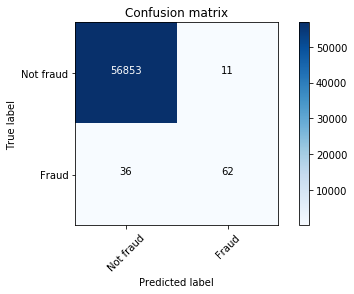

In [6]:
print("Logistic regression results:")
logistic_regression_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=LogisticRegression, normalized=False)

Decision tree results:
Mean accuracy: 0.9991222218320986
Mean precision: 0.75
Mean recall: 0.7346938775510204


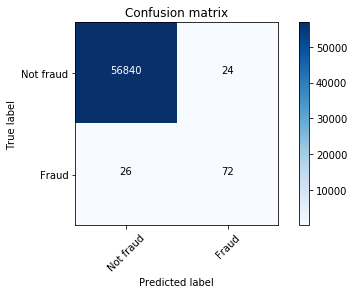

In [7]:
print("Decision tree results:")
decision_tree_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=DecisionTreeClassifier, normalized=False)

As expected, our classifiers had a high accuracy, however, we can see using confusion matrix that we're misclassifying 24 samples as fraud and overlooking 26 samples as not fraud. 

In our application, I'll assume that's more important to not mistake fraudulent samples with non-fraud than the other way around.

Bellow, I'll apply some oversampling and undersampling techniques and I'll compare them to see if we had any improvements.

## Oversampling: Random

In [8]:
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9780379902391068
Mean precision: 0.0649056603773585
Mean recall: 0.8775510204081632


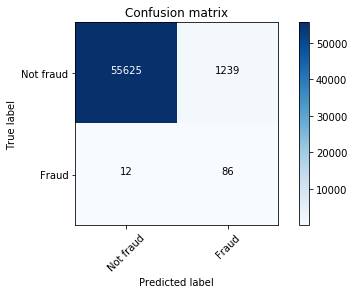

In [9]:
print("Logistic regression results:")
logistic_regression_scores['random_os'] = classify(X_oversampled,
                                                     X_test,
                                                     y_oversampled,
                                                     y_test,
                                                     classifier=LogisticRegression,
                                                     normalized=False)

Decision tree results:
Mean accuracy: 0.9991222218320986
Mean precision: 0.75
Mean recall: 0.7346938775510204


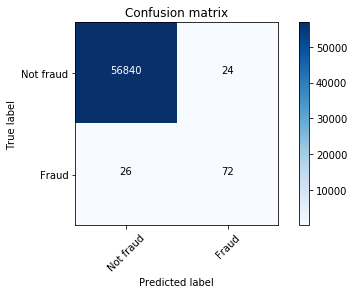

In [10]:
print("Decision tree results:")
decision_tree_scores['random_os'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)

## Oversampling: SMOTE

In [11]:
smote = over_sampling.SMOTE(random_state=0)
X_oversampled, y_oversampled = smote.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9991748885221726
Mean precision: 0.8493150684931506
Mean recall: 0.6326530612244898


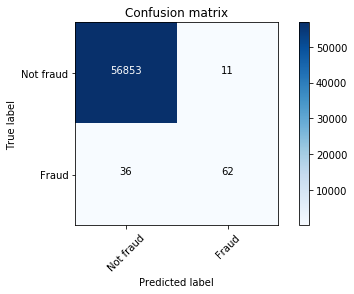

In [12]:
print("Logistic regression results:")
logistic_regression_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=LogisticRegression, normalized=False)

Decision tree results:
Mean accuracy: 0.9977353323268143
Mean precision: 0.41530054644808745
Mean recall: 0.7755102040816326


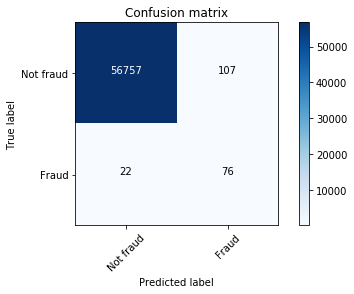

In [13]:
print("Decision tree results:")
decision_tree_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)

## Oversampling: ADASYN

In [14]:
adasyn = over_sampling.ADASYN(random_state=0)
X_oversampled, y_oversampled = adasyn.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9991748885221726
Mean precision: 0.8493150684931506
Mean recall: 0.6326530612244898


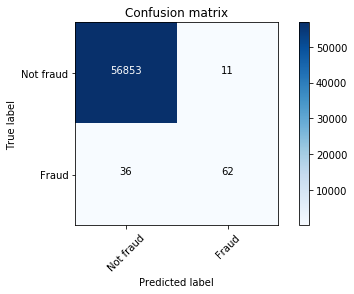

In [15]:
print("Logistic regression results:")
logistic_regression_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=LogisticRegression, normalized=False)

Decision tree results:
Mean accuracy: 0.9976124433833081
Mean precision: 0.39204545454545453
Mean recall: 0.7040816326530612


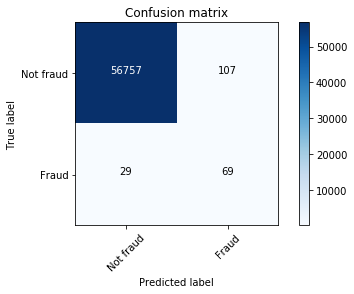

In [16]:
print("Decision tree results:")
decision_tree_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)

## Undersampling: Random

In [17]:
rus = under_sampling.RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9702784312348584
Mean precision: 0.04918032786885246
Mean recall: 0.8877551020408163


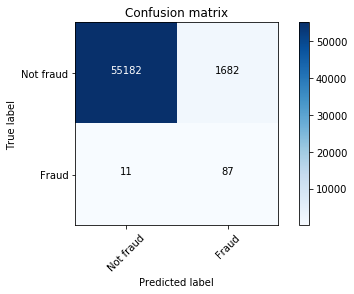

In [18]:
print("Logistic regression results:")
logistic_regression_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=LogisticRegression, normalized=False)

Decision tree results:
Mean accuracy: 0.9086408482848215
Mean precision: 0.01611068991660349
Mean recall: 0.8673469387755102


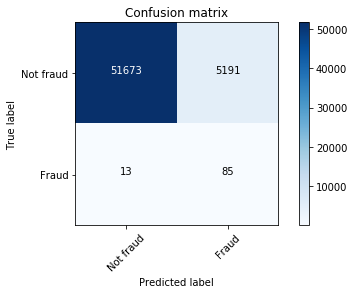

In [19]:
print("Decision tree results:")
decision_tree_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=DecisionTreeClassifier, normalized=False)

### Logistic regression scores

In [20]:
logistic_regression_df = pd.DataFrame(logistic_regression_scores)
logistic_regression_df

,normal,random_os,smote,adasyn,random_us
accuracy,0.999175,0.978038,0.999175,0.999175,0.970278
precision,0.849315,0.064906,0.849315,0.849315,0.049180
recall,0.632653,0.877551,0.632653,0.632653,0.887755


### Decision tree scores

In [21]:
decision_tree_df = pd.DataFrame(decision_tree_scores)
decision_tree_df

,normal,random_os,smote,adasyn,random_us
accuracy,0.999122,0.999122,0.997735,0.997612,0.908641
precision,0.750000,0.750000,0.415301,0.392045,0.016111
recall,0.734694,0.734694,0.775510,0.704082,0.867347


It seems none of our oversampling/undersampling approaches had any improvements to the "normal" results. 

We'll be exploring why.